### Sahil Patil
### 200968154

In [ ]:
!pip install noisereduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import librosa, librosa.display
import noisereduce as nr
import numpy as np
import IPython.display as ipd
import random
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
plt.style.use("dark_background")
from sklearn.metrics import roc_curve
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
root = "gdrive/MyDrive/VoxCeleb_gender/"

In [ ]:
mFiles = os.listdir(root+"males")
fFiles = os.listdir(root+"females")

In [ ]:
sampledMale = random.sample(mFiles,1000)
sampledFemale = random.sample(fFiles,1000)

In [ ]:
print(f"{len(mFiles)} {len(fFiles)}")

3682 2311


### Creating a .csv file

In [ ]:
data = {}
data['relative-path'] = []
data['label'] = []

# for i in sampledMale:
#   rel_path = "males/" + f"{i}"
#   data["relative-path"].append(rel_path)
#   data['label'].append(1)
for i in sampledFemale:
  rel_path = "females/" +f"{i}"
  data["relative-path"].append(rel_path)
  data['label'].append(0)


In [ ]:
df = pd.DataFrame(data)

In [ ]:
df.to_csv('gender.csv')

In [ ]:
df = pd.read_csv("/content/gender.csv")
path = df['relative-path']
label = df['label']
df.drop(["Unnamed: 0"],axis=1,inplace=True)

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(X,y,train_size=0.8,shuffle=True)

In [ ]:
y_train = np.array(list(y_train))
y_train = y_train.reshape((y_train.shape[0],1))

In [ ]:
y_test = np.array(list(y_test))
y_test = y_test.reshape((y_test.shape[0],1))

#### Reading and digitizing audio (ADC): sampling at 16000 points/sec

In [ ]:
rate = 16000

In [ ]:
sig, rate = librosa.load(males,rate)

#### MFCCs feature extraction

In [ ]:
def get_spectrogram(data, mfcc):
  feature = []
  for path in data:
    x, sr = librosa.load(root+path, res_type='kaiser_fast')
    S = librosa.feature.melspectrogram(y=x[:50000], sr=sr, n_mels=mfcc)
    spec = librosa.power_to_db(S, ref=np.max)
    feature.append(spec)
    inputs = np.stack(tuple(feature))
  return inputs

In [ ]:
X1 = get_spectrogram(X_train,13) 

In [ ]:
np.save("X",X1)
np.save("y",y_train) 

#### Baseline model

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16, (4,4), activation='LeakyReLU',input_shape=(13,98,1)))
model.add(tf.keras.layers.Conv2D(8, (2,2), activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(8, (2,2),activation='LeakyReLU'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128,activation='LeakyReLU',kernel_regularizer=tf.keras.regularizers.L1L2(0.2)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64,activation='LeakyReLU',kernel_regularizer=tf.keras.regularizers.L1L2(0.4)))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 95, 16)        272       
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 94, 8)          520       
                                                                 
 batch_normalization (BatchN  (None, 9, 94, 8)         32        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 93, 8)          264       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 46, 8)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 46, 8)          0

In [ ]:
from keras.utils.vis_utils import plot_model

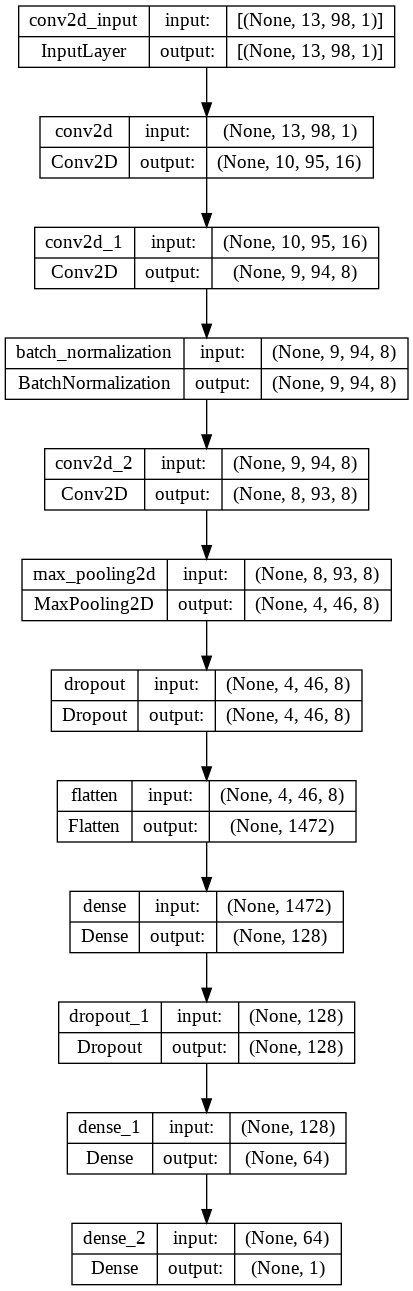

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0005,decay=0.00001,nesterov=True),metrics=['binary_accuracy'])

In [ ]:
hist = model.fit(X_load,y_train,batch_size=128,epochs=22,validation_split=0.3)

Epoch 1/22
18/18 [==============================] - 1s 24ms/step - loss: 1408.0031 - binary_accuracy: 0.5156 - val_loss: 1366.7823 - val_binary_accuracy: 0.4958
Epoch 2/22
18/18 [==============================] - 0s 10ms/step - loss: 1330.4675 - binary_accuracy: 0.5049 - val_loss: 1289.6555 - val_binary_accuracy: 0.4990
Epoch 3/22
18/18 [==============================] - 0s 12ms/step - loss: 1255.2222 - binary_accuracy: 0.5080 - val_loss: 1215.4130 - val_binary_accuracy: 0.5146
Epoch 4/22
18/18 [==============================] - 0s 12ms/step - loss: 1182.2379 - binary_accuracy: 0.5089 - val_loss: 1143.5613 - val_binary_accuracy: 0.5302
Epoch 5/22
18/18 [==============================] - 0s 12ms/step - loss: 1111.4941 - binary_accuracy: 0.5076 - val_loss: 1074.0140 - val_binary_accuracy: 0.5542
Epoch 6/22
18/18 [==============================] - 0s 9ms/step - loss: 1043.0083 - binary_accuracy: 0.4987 - val_loss: 1006.7043 - val_binary_accuracy: 0.5656
Epoch 7/22
18/18 [=================

In [ ]:
def get_one_feature(path,mfcc):
  feature = []
  x, sr = librosa.load(root+path, res_type='kaiser_fast')
  S = librosa.feature.melspectrogram(y=x[:50000], sr=sr, n_mels=mfcc)
  spec = librosa.power_to_db(S, ref=np.max)
  feature.append(spec)
  inputs = np.stack(tuple(feature))
  return inputs

#### Pickling the model and then loading it

In [ ]:
X = np.load("X.npy")
y = np.load("y.npy")

In [ ]:
pickle.dump(model, open('pickled_model.pkl', 'wb'))

In [ ]:
model = pickle.load(open("pickled_model.pkl","rb"))

In [ ]:
y_pred = model.predict(X).ravel()
fpr, tpr ,thresh = roc_curve(y, y_pred)

100/100 [==============================] - 2s 14ms/step


In [ ]:
x = np.linspace(0,1,1552)
y = x

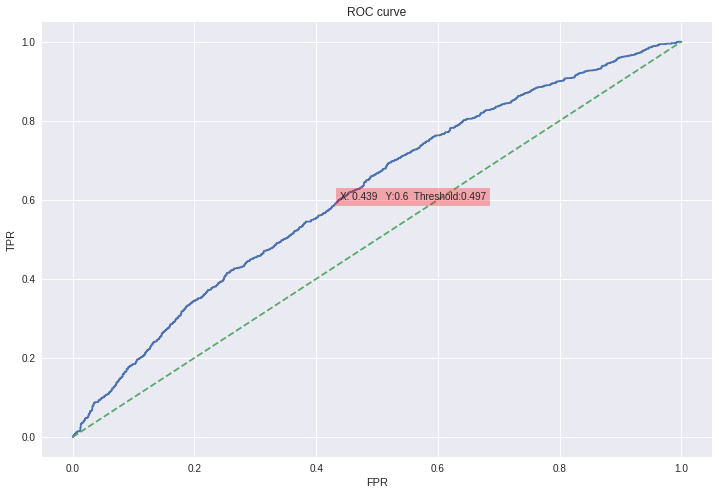

In [ ]:
plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(fpr, tpr)
plt.plot(x,y,"--",)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
index = 800
s = f"X: {np.round(fpr[index],3)}   Y:{np.round(tpr[index],3)}  Threshold:{thresh[index]:0.3f}"
ax.text(fpr[index], tpr[index], s,bbox=dict(facecolor='red', alpha=0.3))
threshold = thresh[index]
plt.show()

In [ ]:
prediction = model.predict(get_one_feature("females/1282.m4a",13))
if prediction>=threshold:
  print(f"male {prediction}")
else:
  print(f"female {prediction}") 

1/1 [==============================] - 0s 105ms/step
female [[0.4864702]]


###getting spectrogram images for training VGG16


In [ ]:
image_root = "/content/gdrive/MyDrive/spectrogram_images/"

In [ ]:
plt.style.use("seaborn")

In [ ]:
def save_images(path):
  filec = 0
  for paths in path:
    byteCode, rate = librosa.load(root+paths,16000)
    reduced_sig = nr.reduce_noise(byteCode,rate)
    melspec = librosa.feature.melspectrogram(reduced_sig)
    log_mel_spec = librosa.amplitude_to_db(melspec)
    librosa.display.specshow(log_mel_spec)
    plt.axis("off")
    plt.savefig(image_root+f"females/train/{filec}.png", bbox_inches='tight',pad_inches = 0)
    print(filec)
    filec = filec+1

In [ ]:
train_data = ImageDataGenerator(rescale=1./255)
test_data = ImageDataGenerator(rescale=1./255)

In [ ]:
root_dir = '/content/gdrive/MyDrive/spectrogram_images'
train_MF = os.path.join(root_dir,'train')
test_MF = os.path.join(root_dir,'test')

male_train = os.path.join(train_MF,'males')
female_train = os.path.join(train_MF,'females')

male_test = os.path.join(test_MF,'males')
female_test = os.path.join(test_MF,'females')

In [ ]:
input_images = train_data.flow_from_directory(
    train_MF,
    target_size=(224,224),
    color_mode='rgb',
    class_mode="binary",
    batch_size=20
)

Found 1600 images belonging to 2 classes.


In [ ]:
test_images = test_data.flow_from_directory(
    test_MF,
    target_size=(224,224),
    color_mode='rgb',
    class_mode="binary",
    batch_size=20
)

Found 400 images belonging to 2 classes.


In [ ]:
from keras.applications.vgg16 import VGG16
def vgg16():
  base_model = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
  base_model.trainable = False

  vgg = tf.keras.Sequential([
      base_model,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  vgg.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0005,nesterov=True), metrics = ['binary_accuracy'])
  return vgg

In [ ]:
vgg = vgg16()

In [ ]:
vgg_hist = vgg.fit(
      input_images,
      validation_data=test_images,
      epochs=10,
      verbose=1)

Epoch 1/10
80/80 [==============================] - 48s 591ms/step - loss: 0.6883 - binary_accuracy: 0.5612 - val_loss: 0.6277 - val_binary_accuracy: 0.7300
Epoch 2/10
80/80 [==============================] - 13s 161ms/step - loss: 0.6265 - binary_accuracy: 0.6694 - val_loss: 0.5754 - val_binary_accuracy: 0.8025
Epoch 3/10
80/80 [==============================] - 12s 153ms/step - loss: 0.5743 - binary_accuracy: 0.7337 - val_loss: 0.5377 - val_binary_accuracy: 0.7775
Epoch 4/10
80/80 [==============================] - 14s 176ms/step - loss: 0.5357 - binary_accuracy: 0.7837 - val_loss: 0.5100 - val_binary_accuracy: 0.8125
Epoch 5/10
80/80 [==============================] - 12s 152ms/step - loss: 0.5173 - binary_accuracy: 0.7788 - val_loss: 0.4990 - val_binary_accuracy: 0.8125
Epoch 6/10
80/80 [==============================] - 12s 150ms/step - loss: 0.4949 - binary_accuracy: 0.8044 - val_loss: 0.4634 - val_binary_accuracy: 0.8400
Epoch 7/10
80/80 [==============================] - 12s 15

In [ ]:
tf.keras.models.save_model(vgg,"vgg.h5")

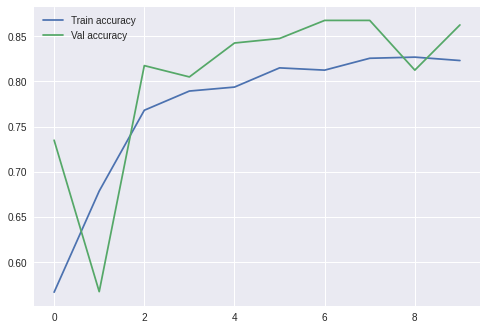

In [ ]:
plt.plot(vgg_hist.epoch,vgg_hist.history['acc'])
plt.plot(vgg_hist.epoch,vgg_hist.history['val_acc'])
plt.legend(['Train accuracy','Val accuracy'])

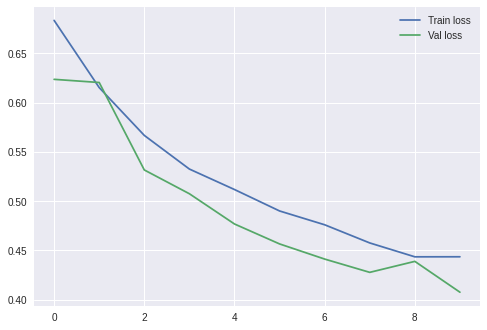

In [ ]:
plt.plot(vgg_hist.epoch,vgg_hist.history['loss'])
plt.plot(vgg_hist.epoch,vgg_hist.history['val_loss'])
plt.legend(['Train loss','Val loss'])

In [ ]:
y_true = test_images.classes

In [ ]:
y_pred = vgg.predict(test_images)

20/20 [==============================] - 3s 128ms/step


In [ ]:
# fpr, tpr ,thresh = roc_curve(y_true, y_pred)

In [ ]:
# x = np.linspace(0,1,2)
# y = x

In [ ]:
# plt.style.use("seaborn")
# fig, ax = plt.subplots(figsize=(12,8))
# plt.plot(fpr, tpr,marker='X',markersize=3)
# plt.plot(x,y,"--",)
# plt.xlabel("FPR")
# plt.ylabel("TPR")
# plt.title("ROC curve")
# plt.show()

In [ ]:
from keras.applications.inception_v3 import InceptionV3
def inception():
  base_model = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)
  base_model.trainable = False

  inc = tf.keras.Sequential([
      base_model,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  inc.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.SGD(learning_rate = 0.0005,momentum=True), metrics = ['binary_accuracy'])
  return inc

In [ ]:
inc = inception()

In [ ]:
inc_hist = inc.fit(
      input_images,
      steps_per_epoch=80,
      epochs=5,
      validation_data=test_images)

Epoch 1/5
80/80 [==============================] - 57s 180ms/step - loss: 4.1908 - binary_accuracy: 0.7156 - val_loss: 4.5799 - val_binary_accuracy: 0.8250
Epoch 2/5
80/80 [==============================] - 13s 165ms/step - loss: 11.1957 - binary_accuracy: 0.7837 - val_loss: 19.5912 - val_binary_accuracy: 0.7150
Epoch 3/5
80/80 [==============================] - 14s 177ms/step - loss: 13.1183 - binary_accuracy: 0.8369 - val_loss: 25.0327 - val_binary_accuracy: 0.7500
Epoch 4/5
80/80 [==============================] - 13s 163ms/step - loss: 12.2891 - binary_accuracy: 0.8744 - val_loss: 22.9494 - val_binary_accuracy: 0.8450
Epoch 5/5
80/80 [==============================] - 13s 163ms/step - loss: 8.8884 - binary_accuracy: 0.9106 - val_loss: 21.0640 - val_binary_accuracy: 0.8650


# Models used
## - CNN architecture for MFCC features 
### This is a pretty straight-forward architecture
### Train accuracy = 55%
### Validation accuracy = 58%
### This uses SGD along with momentum and decay
### The ROC curve provides the optimal threshold for classifying the target label, in this case it is 0.497
## - VGG16 for spectrogram images

### VGG16 here is pre-trained on imagenet dataset and has pretty good accuracy for classifying male female
### Train accuracy = 82%
### Validation accuracy = 86%
### SGD is used for optimizing the loss function (binary crossentropy) along with Nesterov momentum.

### Inception also pretrained on imagenet with same optmizers as VGG is also performing well.
### Train accuracy = 91%
### Validation accuracy = 86%